In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile
import glob 

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications

In [2]:
# set seed for random functions 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

print(tf.__version__)

2.9.2


In [3]:
data_dir = 'data/mini_speech_commands'
data_path = pathlib.Path(data_dir)
filename = 'mini_speech_commands.zip'
url = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"
if not data_path.exists():
  tf.keras.utils.get_file(filename, origin=url, extract=True, cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


In [4]:
os.listdir(data_dir)

['go', 'down', 'left', 'up', 'README.md', 'right', 'no', 'yes', 'stop']

In [5]:
commands = ['up', 'no', 'stop', 'left', 'right', 'go', 'down', 'yes']

In [6]:
glob.glob(data_dir + '/*')

['data/mini_speech_commands/go',
 'data/mini_speech_commands/down',
 'data/mini_speech_commands/left',
 'data/mini_speech_commands/up',
 'data/mini_speech_commands/README.md',
 'data/mini_speech_commands/right',
 'data/mini_speech_commands/no',
 'data/mini_speech_commands/yes',
 'data/mini_speech_commands/stop']

In [7]:
wav_file_names = glob.glob(data_dir + '/*/*')
np.random.shuffle(wav_file_names)
print(len(wav_file_names))
for file_name in wav_file_names[:5]:
  print(file_name)

8000
data/mini_speech_commands/left/bfbd0e6b_nohash_1.wav
data/mini_speech_commands/left/a709ddd3_nohash_1.wav
data/mini_speech_commands/down/324210dd_nohash_0.wav
data/mini_speech_commands/up/325a0c39_nohash_0.wav
data/mini_speech_commands/right/8f4c551f_nohash_3.wav


Now let's look at how create a (spectrogram, label) data pair. 

First let's look at how to decode a wave file.

In [8]:
filepath = 'data/mini_speech_commands/stop/f632210f_nohash_1.wav'
rate, data = wavfile.read(filepath)
print("rate = {}, data.shape = {}, data.dtype = {}".format(rate, data.shape, data.dtype))

rate = 16000, data.shape = (13654,), data.dtype = int16


Let's find out if there are any files in the dataset that have less than 1600 samples. 

In [9]:
count = 0
for filepath in wav_file_names:
  rate, data = scipy.io.wavfile.read(filepath)
  if data.shape[0] < 16000: 
    count += 1
    #print(filepath)
print("{} files have N < 16000!".format(count))

822 files have N < 16000!


Find a random wav file that has 16000 samples

In [10]:
def find_random_full():
  for filepath in wav_file_names:
    rate, data = scipy.io.wavfile.read(filepath)
    if data.shape[0] == 16000:
      print(filepath)
      return 
find_random_full()

data/mini_speech_commands/left/bfbd0e6b_nohash_1.wav


This means we need to zero pad the wave file data to 16000 length. Let's take a look at one of the "short" files.

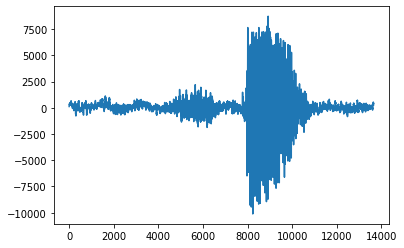

In [11]:
filepath = 'data/mini_speech_commands/stop/f632210f_nohash_1.wav'
rate, data = scipy.io.wavfile.read(filepath)
plt.plot(data)

Now let's pad the data.

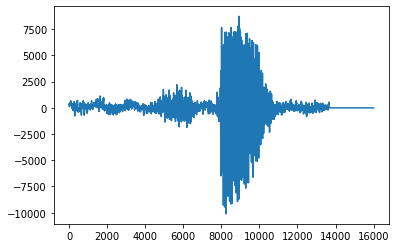

In [12]:
padded_data = np.zeros((16000,), dtype=np.int16)
padded_data[:data.shape[0]] = data
plt.plot(padded_data)

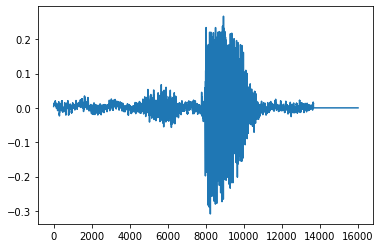

In [13]:
padded_data = np.zeros((16000,), dtype=np.int16)
padded_data[:data.shape[0]] = data
norm_data = np.array(padded_data/32768.0, dtype=np.float32)
plt.plot(norm_data)

Now let's compute the spectrogram of the data.

spec: min = 0.0, max = 2089.085693359375, shape = (129, 124), dtype = float32


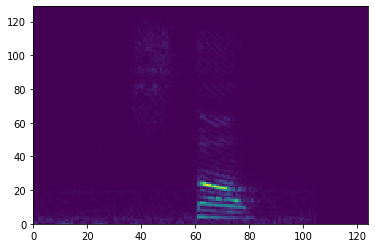

In [14]:
f, t, spec = scipy.signal.stft(padded_data, fs=16000, nperseg=255, noverlap = 124, nfft=256)
spec = np.abs(spec)
print("spec: min = {}, max = {}, shape = {}, dtype = {}".format(np.min(spec), np.max(spec), spec.shape, spec.dtype))
plt.pcolormesh(spec)

Now let's plot the same using a log scale.

0.0


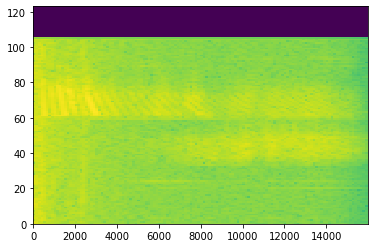

In [15]:
import matplotlib
import matplotlib.cm as cm
#plt.pcolormesh(np.log(spec + np.finfo(float).eps))
X = np.linspace(0, spec.shape[0]*spec.shape[1], num=129, dtype=int)
Y = range(124)
log_spec = np.log(spec.T + np.finfo(float).eps)
plt.pcolormesh(X, Y, log_spec)
#plt.pcolormesh(np.log(spec), cmap=cm.gray)
print(spec[20][120])

Now let's do this for a file that has 16000 samples.

spec: min = 2.488167410774622e-05, max = 464.5478515625, shape = (129, 124), dtype = float32


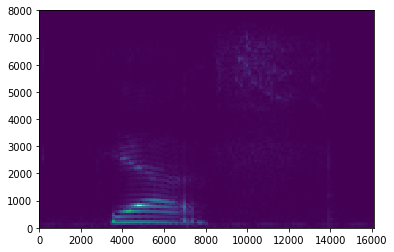

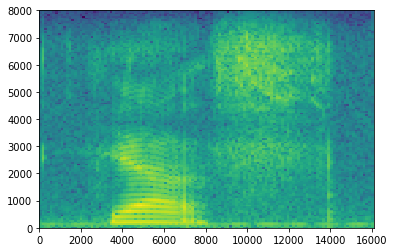

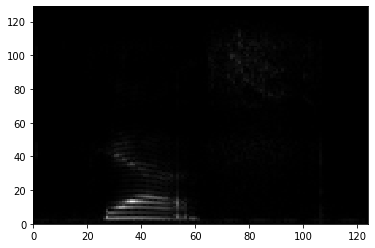

In [16]:
filepath = 'data/mini_speech_commands/yes/00f0204f_nohash_0.wav'
rate, data = scipy.io.wavfile.read(filepath)
f, t, spec = scipy.signal.stft(data, fs=16000, nperseg=255, noverlap = 124, nfft=256)
spec = np.abs(spec)
print("spec: min = {}, max = {}, shape = {}, dtype = {}".format(np.min(spec), np.max(spec), spec.shape, spec.dtype))
X = t * 129*124
plt.pcolormesh(X, f, spec)
plt.show()
Y = range(129)
log_spec = np.log(spec + np.finfo(float).eps)
plt.pcolormesh(X, f, log_spec)
plt.show()
plt.pcolormesh(spec, cmap=cm.gray)

Now let's figure out how to get the label from the file path.

In [17]:
filepath = 'data/mini_speech_commands/stop/f632210f_nohash_1.wav'
print(filepath.split(os.path.sep))
print(filepath.split(os.path.sep)[-2])

['data', 'mini_speech_commands', 'stop', 'f632210f_nohash_1.wav']
stop


Given a label name, let us get the label id.

In [18]:
commands = np.array(['up', 'no', 'stop', 'left', 'right', 'go', 'down', 'yes'])
cmd = 'left'
print(np.where(commands == cmd)[0][0])


3


Now with tensors.

In [19]:
filepath = 'data/mini_speech_commands/stop/f632210f_nohash_1.wav'
vals = tf.strings.split(filepath, os.path.sep)
cmd = vals[-2]
label_id = tf.argmax(tf.cast(cmd == commands, "uint32"))
print(vals)
print(cmd)
print(label_id)

tf.Tensor([b'data' b'mini_speech_commands' b'stop' b'f632210f_nohash_1.wav'], shape=(4,), dtype=string)
tf.Tensor(b'stop', shape=(), dtype=string)
tf.Tensor(2, shape=(), dtype=int64)


Now let's write a function to extract the (spectrogram, label) 


In [20]:
def get_spec_label_pair_np(filepath):
  print(type(filepath))
  # read wav file
  rate, data = scipy.io.wavfile.read(filepath)
  # pad data with zeros till 16000
  padded_data = np.zeros((16000,), dtype=np.int16)
  padded_data[:data.shape[0]] = data  
  # normalize
  padded_data = np.array(padded_data/32768.0, dtype=np.float32)
  # compute spectrogram
  f, t, spec = signal.stft(padded_data, fs=16000, nperseg=255, noverlap = 124, nfft=256)
  # compute magnitude
  spec = np.abs(spec)
  # get label
  cmd = filepath.split(os.path.sep)[-2]
  label_id = np.where(commands == cmd)[0][0]
  # return tuple
  return (spec, label_id)

Try zero padding for Tensor.

In [21]:
filepath = 'data/mini_speech_commands/stop/f632210f_nohash_1.wav'
file_data = tf.io.read_file(filepath)
data, rate = tf.audio.decode_wav(file_data)
print("data.shape = {}".format(data.shape))
data = tf.squeeze(data, axis=-1)
print("data.shape = {}".format(data.shape))
print(data, rate)
zero_padding = tf.zeros((16000 - tf.shape(data)[0]), dtype=tf.float32)
print(zero_padding)
equal_length = tf.concat([data, zero_padding], 0)
print(equal_length)

data.shape = (13654, 1)
data.shape = (13654,)
tf.Tensor([0.00393677 0.00704956 0.00674438 ... 0.01116943 0.01425171 0.00830078], shape=(13654,), dtype=float32) tf.Tensor(16000, shape=(), dtype=int32)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(2346,), dtype=float32)
tf.Tensor([0.00393677 0.00704956 0.00674438 ... 0.         0.         0.        ], shape=(16000,), dtype=float32)


In [22]:
def stft(x):
    f, t, spec = scipy.signal.stft(x.numpy(), fs=16000, nperseg=255, noverlap = 124, nfft=256)
    return tf.convert_to_tensor(np.abs(spec))

def get_spec_label_pair(filepath):
  print(type(filepath))
  # read wav file
  file_data = tf.io.read_file(filepath)
  data, rate = tf.audio.decode_wav(file_data)
  data = tf.squeeze(data, axis=-1)
  # add zero padding for N < 16000
  zero_padding = tf.zeros([16000] - tf.shape(data), dtype=tf.float32)
  # combine data with zero padding
  padded_data = tf.concat([data, zero_padding], 0)
  # compute spectrogram
  spec = tf.py_function(func=stft, inp=[padded_data], Tout=tf.float32)       
  spec.set_shape((129, 124,))
  spec = tf.expand_dims(spec, -1)
  # get label
  cmd = tf.strings.split(filepath, os.path.sep)[-2]
  label_id = tf.argmax(tf.cast(cmd == commands, "uint32"))
  # return tuple
  return (spec, label_id)

Now let's compute (spectrogram, label) pairs for all the wave files.

Let's first partition the dataset.

In [23]:
train_files = wav_file_names[:6400]
val_files = wav_file_names[6400:7200]
test_files = wav_file_names[7200:]

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_ds = tf.data.Dataset.from_tensor_slices(val_files)
test_ds = tf.data.Dataset.from_tensor_slices(test_files)
for val in train_ds.take(5):
  print(val)

tf.Tensor(b'data/mini_speech_commands/left/bfbd0e6b_nohash_1.wav', shape=(), dtype=string)
tf.Tensor(b'data/mini_speech_commands/left/a709ddd3_nohash_1.wav', shape=(), dtype=string)
tf.Tensor(b'data/mini_speech_commands/down/324210dd_nohash_0.wav', shape=(), dtype=string)
tf.Tensor(b'data/mini_speech_commands/up/325a0c39_nohash_0.wav', shape=(), dtype=string)
tf.Tensor(b'data/mini_speech_commands/right/8f4c551f_nohash_3.wav', shape=(), dtype=string)


Now let's create spectrogram datasets for training, validation, and testing.

In [26]:
train_ds = train_ds.map(get_spec_label_pair)
val_ds = val_ds.map(get_spec_label_pair)
test_ds = test_ds.map(get_spec_label_pair)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


Let's look at some ds entries now.

In [27]:
for spec, label_id in train_ds.take(1):
  print("spec.shape = {}, label_id = {}".format(spec.shape, label_id))

spec.shape = (129, 124, 1), label_id = 3


Set batch size - very important! Otherwise we will get a mismatch for tensor size during model.fit().

In [28]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Now let's create the model.

In [29]:
input_shape = (129, 124, 1)
num_labels = 8 
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

Explanation of norm_layer.

In [30]:
x = [(1, 'a'), (2, 'b'), (3, 'c')]
fn = lambda x, _: x
[fn(*val) for val in x]

[1, 2, 3]

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [32]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=15),
)

Epoch 1/10
100/100 [==============================] - 31s 301ms/step - loss: 1.7825 - accuracy: 0.3539 - val_loss: 1.3631 - val_accuracy: 0.5663
Epoch 2/10
100/100 [==============================] - 31s 314ms/step - loss: 1.1910 - accuracy: 0.5736 - val_loss: 0.9387 - val_accuracy: 0.6825
Epoch 3/10
100/100 [==============================] - 30s 297ms/step - loss: 0.9152 - accuracy: 0.6759 - val_loss: 0.7890 - val_accuracy: 0.7275
Epoch 4/10
100/100 [==============================] - 35s 349ms/step - loss: 0.7487 - accuracy: 0.7269 - val_loss: 0.6712 - val_accuracy: 0.7650
Epoch 5/10
100/100 [==============================] - 31s 309ms/step - loss: 0.6298 - accuracy: 0.7733 - val_loss: 0.5942 - val_accuracy: 0.7950
Epoch 6/10
100/100 [==============================] - 29s 293ms/step - loss: 0.5425 - accuracy: 0.8084 - val_loss: 0.5472 - val_accuracy: 0.8138
Epoch 7/10
100/100 [==============================] - 31s 311ms/step - loss: 0.4738 - accuracy: 0.8322 - val_loss: 0.5068 - val_ac

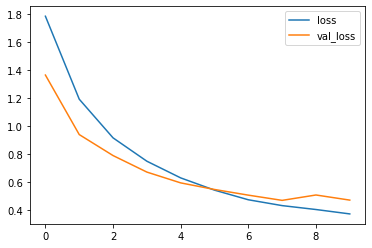

In [33]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [36]:
model.save('audioml.sav')

Let's try some inference.

## Test Data

In [42]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())
print(type(test_audio[0]))
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

<class 'numpy.ndarray'>


In [40]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 1s 35ms/step
Test set accuracy: 84%


## Convert to Lite

In [38]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('audioml.sav') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('audioml.tflite', 'wb') as f:
  f.write(tflite_model)

Download saved model. Need to use Chrome browser.

In [ ]:
from google.colab import files
files.download('audioml.tflite') 